In [1]:
## import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import lusee 


In [2]:
O = lusee.Observation (lunar_day = "2025-02-01 13:00:00 to 2025-03-22 16:00:00",lun_lat_deg = -23, deltaT_sec=60)

In [29]:
SL = [lusee.Satellite (semi_major_km=3000, eccentricity=0.0, inclination_deg=20)]
      #,
      #lusee.Satellite (semi_major_km=6000, eccentricity=0.0, inclination_deg=70),
      #lusee.Satellite ()]
TL = [lusee.ObservedSatellite (O,S) for S in SL]

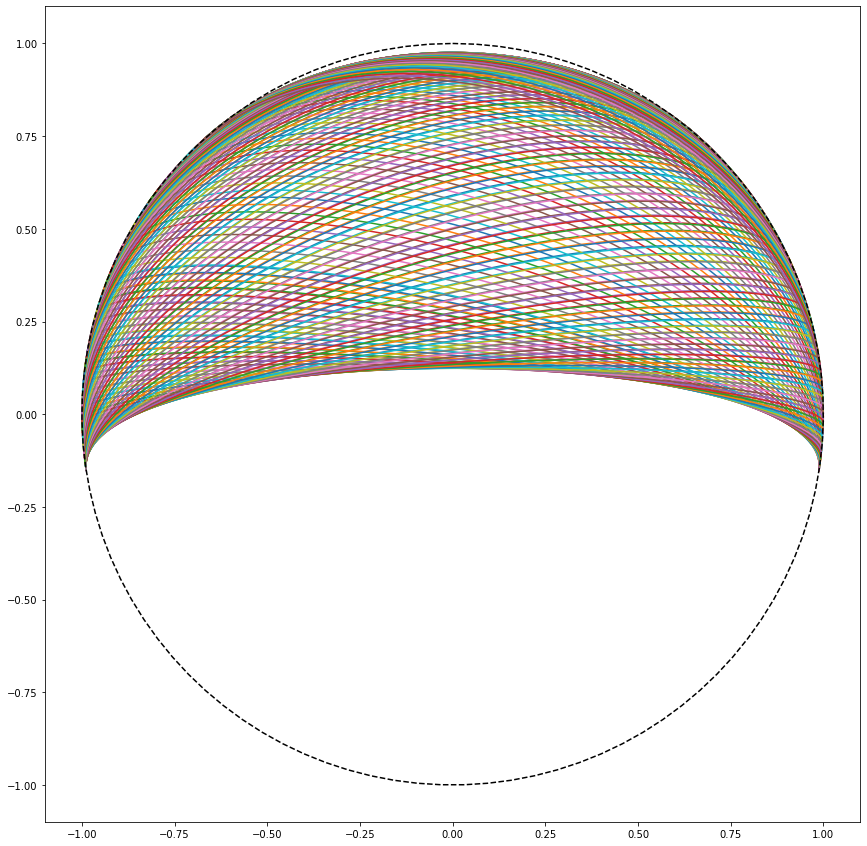

In [30]:
fig = plt.figure(figsize=(15,15))
for i,T in enumerate(TL):
    ax = fig.add_subplot(1,1,i+1, adjustable='box', aspect=1.0)
    T.plot_tracks(ax,lin_map=False)
    #ax.axis('off')

th=np.linspace(0,2*np.pi,100)
plt.plot(np.sin(th),np.cos(th),'k--')
plt.savefig('orbital_coverage.pdf')

212.0


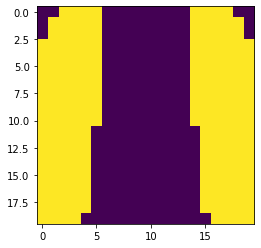

In [32]:
m = TL[0].get_track_coverage(Nmu=20,Nphi=20)
print (m.sum())
plt.imshow(m)

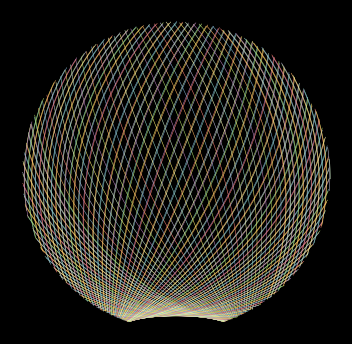

In [13]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, adjustable='box', aspect=1.0)
transits = TL[0].get_transit_indices()
az = TL[0].az_rad()
alt = TL[0].alt_rad()
X = np.sin(az) * (1-alt/(np.pi/2))
Y = np.cos(az) * (1-alt/(np.pi/2))
for s, e in transits:
   ax.plot(X[s:e], Y[s:e],lw=0.5)
ax.axis('off')
plt.tight_layout()
plt.savefig('orbitalblack.png',dpi=300)

In [67]:
[S.period*24 for S in SL]

[4.095259958243699, 11.58314434878343, 10.832792111632173]

1263.1774318881467 2445.880255751023 0.05012779350215441 0.18794044687693173 -0.7386810121749476 0.7386657758447654
4262.958339203277 5742.989409652617 0.5709157833473594 1.0361578069346704 -0.2601296147630971 0.2601384517097813
1848.6072031466595 8807.351169752365 0.10735917229892614 2.436915659683599 -0.744676912347821 0.9661451255010964


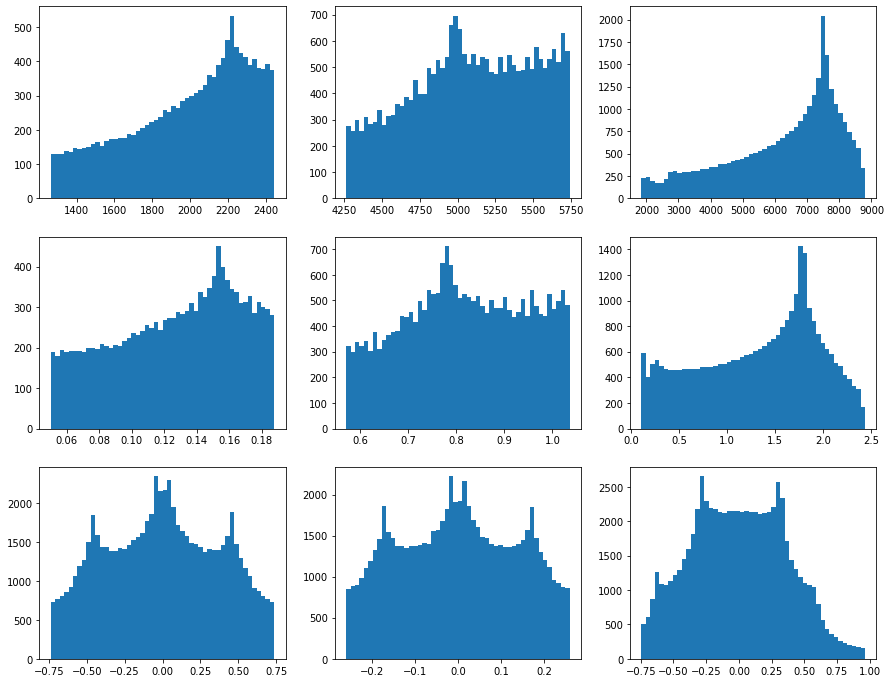

In [86]:
#fig = plt.figure(figsize=(15,5))
#ax = [fig.add_subplot(3,3,i+1, adjustable='box', aspect=1.0) for i in range(3)]

fig,ax = plt.subplots(3,3, figsize=(15,12))
for i,T in enumerate(TL):
    r = T.dist_km()
    ndx=T.get_transit_indices()
    di = np.hstack([r[s:e] for s,e in ndx])
    pw = di**2*1e6*2*np.pi*50e6*1e-22
    dop = (r[1:]-r[:-1])/60
    ax[0,i].hist(di,bins=50)
    ax[1,i].hist(pw,bins=50)
    ax[2,i].hist(dop,bins=50)
    print (di.min(), di.max(), pw.min(), pw.max(), dop.min(), dop.max())

In [232]:
## we need to do it manually
RMoon = 1737
dec = -O.lun_lat_deg/180*np.pi
oo = RMoon*np.array([np.cos(dec), 0,np.sin(dec)])
rhat = oo/np.sqrt(np.dot(oo,oo))
nhat = np.array([np.sin(dec), 0,-np.cos(dec)])
ehat = np.array([0, 1,0])

In [233]:
D = T.posxyz-oo[None,:]
lz = np.sum(D*rhat[None,:],axis=1)
ln = np.sum(D*nhat[None,:],axis=1)
le = np.sum(D*ehat[None,:],axis=1)
rr = np.sqrt(lz**2+ln**2+le**2)
alt = np.arcsin(lz/rr)
az = np.arctan2(le,ln)

In [234]:
visible = alt > 0
passes = []
if visible[0]:
    si = 0
    tostate = False
else:
    tostate = True

for i, v in enumerate(visible):
    if v == tostate:
        if not tostate:
            passes.append((si, i))
        else:
            si = i
        tostate = not tostate

Text(0, 0.5, 'N-S')

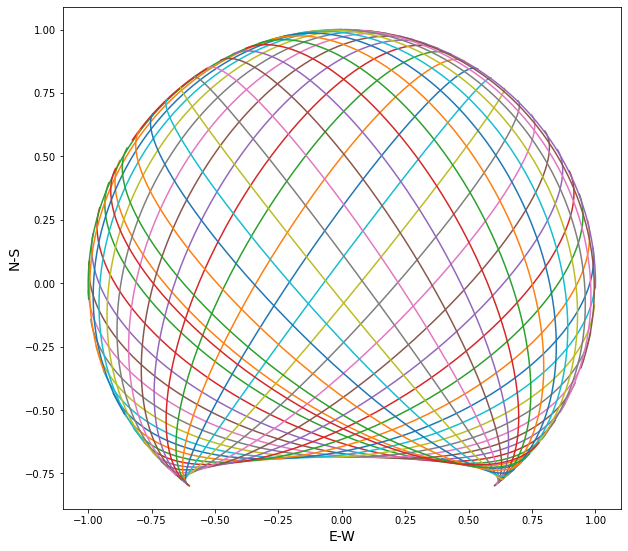

In [235]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, adjustable='box', aspect=1.0)
X = np.sin(az) * np.cos(alt)
Y = np.cos(az) * np.cos(alt)
for s, e in passes:
    ax.plot(X[s:e], Y[s:e])
plt.xlabel('E-W',fontsize=14)
plt.ylabel('N-S',fontsize=14)

Text(0, 0.5, 'N-S')

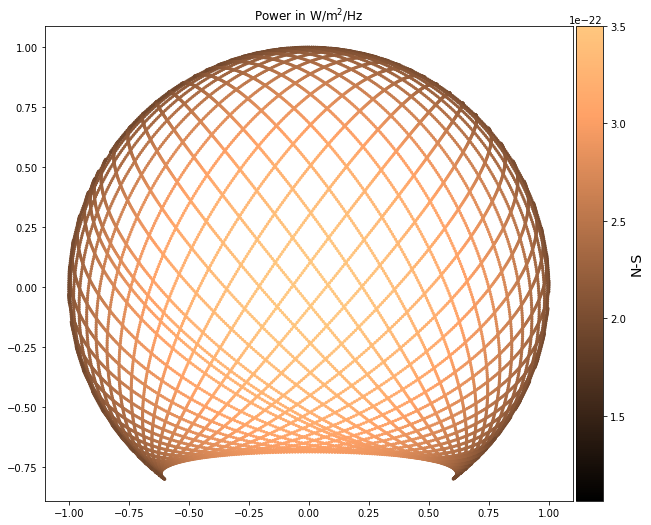

In [241]:
import matplotlib
import matplotlib.cm as cm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, adjustable='box', aspect=1.0)
X = np.sin(az) * np.cos(alt)
Y = np.cos(az) * np.cos(alt)
pwr = 2/((rr*1e3)**2*2*np.pi*50e6)
norm = matplotlib.colors.Normalize(vmin=pwr.min(), vmax=pwr.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.copper)
for s, e in passes:
    clr = mapper.to_rgba(pwr[s:e])
    w = np.where(pwr[s:e]>1e-22)
    ax.scatter(X[s:e][w],Y[s:e][w],color=clr[w],marker='.',s=20)
    ax.scatter(X[s:e],Y[s:e],color=clr,marker='.',s=1)
    
    #for x_,y_,p_,c_ in zip(X[s:e],Y[s:e],pwr[s:e],clr):    
    #     if p_>1e-22:
    #        ax.plot(x_,y_,'o',color=c_)
    #    else:
    #        ax.plot(x_,y_,'.',color=c_)
        #ax.plot(X[s:e], Y[s:e],color = )
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.title('Power in W/m$^2$/Hz')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mapper, cax=cax)
plt.xlabel('E-W',fontsize=14)
plt.ylabel('N-S',fontsize=14)


In [237]:
vel = (rr[1:]-rr[:-1])/60

Text(0, 0.5, 'Dopper v [km/s]')

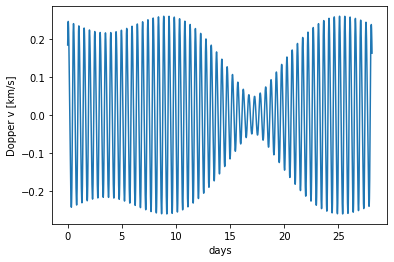

In [248]:
plt.plot(np.arange(len(vel))/(24*60),vel)
plt.xlabel('days')
plt.ylabel('Dopper v [km/s]')

In [185]:
len(O.times)/24/60

28.125694444444445

In [240]:
len(passes)

54

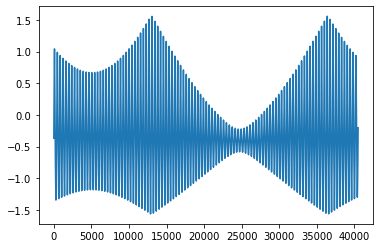

In [197]:
(alt<0).sum()/len(alt)
plt.plot(alt)

In [251]:
rr.min(), 6000-1737

(4264.18432680373, 4263)